##Install gymnasium and pygame

In [ ]:
!pip install gymnasium
!pip install gymnasium[box2d]
!pip install pygame
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Import

In [ ]:
import gymnasium as gym
import pygame
import random
from gym import logger as gymlogger
from gym.wrappers.record_video import RecordVideo
gymlogger.set_level(40)
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

##**Function for video rendering purpose**<br>
Reference : https://cutt.ly/F3JsIa5

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)

Video Rendering Part Reference :
https://cutt.ly/F3JsIa5

"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
  return env

# **Functions for task 1 (Cliff-Walking)**

In [ ]:

def cliff_render_reward(pol,ep_len=300):
    env = env = gym.make("CliffWalking-v0",render_mode=None)
    s = env.reset()[0]
    r = 0
    for i in range(ep_len):
        act = pol[s]
        observation, reward, terminated, truncated,info = env.step(act)
        r += reward
        if terminated == True:
            return r,'Success'
            break
        s = observation
    return r,'Failed'



def cliff_render(env,pol,ep_len = 300):
    s = env.reset()[0]
    for i in range(ep_len):
        observation, reward, terminated, truncated = env.step(pol[s])
        env.render()

        if terminated == True:
            break
        s = observation

def decode(state):
    y = state%12
    state = state - y
    x = state/12
    return int(x),y

def get_opt_pol(Q):
    pol = [0 for i in range(48)]
    for i in range(37):
        pol[i] = np.argmax(Q[i])
    return pol

def q_learning(env,n_episode=2000,alpha=0.5,gamma=1):

    rew_per_episode = []

    Q = [[np.random.randint(0,10) for j in range(4)] for i in range(48)]
    for i in range(37,47):
        Q[i] = [-np.inf for j in range(4)]
    Q[47] = [0 for j in range(4)]

    for i in range(n_episode):
        s = env.reset()[0]
        len_ep = 0
        sum_reward = 0
        while True:
            len_ep += 1
            a = np.random.randint(0,4)
            observation, reward, terminated, truncated, info= env.step(a)
            Q[s][a] +=  alpha*(reward + gamma*np.max(Q[observation])-Q[s][a])
            s = observation
            sum_reward += reward
            if terminated == True or len_ep>500:
                cur_opt_pol = get_opt_pol(Q)
                rew_per_episode.append(sum_reward)
                break

    return Q,np.array(get_opt_pol(Q)),rew_per_episode


def q_learning_eps_greedy(env,epsilon,n_episode=2000,alpha=0.0001,gamma=1):

    rew_per_episode = []

    Q = [[np.random.randint(0,2) for j in range(4)] for i in range(48)]
    for i in range(37,47):
        Q[i] = [-np.inf for j in range(4)]
    Q[47] = [0 for j in range(4)]

    for i in range(n_episode):
        s = env.reset()[0]
        sum_reward = 0
        ep_len = 0
        while True:
            ep_len += 1
            a = np.random.choice([np.random.randint(0,4),np.argmax(Q[s])],p=[epsilon,1-epsilon])
            observation, reward, terminated, truncated, info= env.step(a)
            Q[s][a] +=  alpha*(reward + gamma*np.max(Q[observation])-Q[s][a])
            s = observation
            sum_reward += reward
            if terminated == True or ep_len > 500:
                rew_per_episode.append(sum_reward)
                break

    return Q,np.array(get_opt_pol(Q)),rew_per_episode


def q_learning_eps_greedy_decreasing(env,epsilon,n_episode=2000,alpha=0.01,gamma=1):

    rew_per_episode = []

    Q = [[np.random.randint(0,2) for j in range(4)] for i in range(48)]
    for i in range(37,47):
        Q[i] = [-np.inf for j in range(4)]
    Q[47] = [0 for j in range(4)]
    for i in range(n_episode):
        s = env.reset()[0]
        sum_reward = 0
        ep_len = 0
        while True:
            ep_len += 1
            a = np.random.choice([np.random.randint(0,4),np.argmax(Q[s])],p=[epsilon,1-epsilon])
            observation, reward, terminated, truncated, info= env.step(a)
            Q[s][a] +=  alpha*(reward + gamma*np.max(Q[observation])-Q[s][a])
            s = observation
            sum_reward += reward
            if terminated == True or ep_len>500:
                rew_per_episode.append(sum_reward)
                break

        epsilon = 0.99907939*epsilon

    return Q,np.array(get_opt_pol(Q)),rew_per_episode


# **Q1**

In [ ]:
import time
alpha = [0.0005,0.005,0.01,0.07,0.1]
pol_list = []
rew_per_ep = []
run_time_list = []
for a in alpha:
    print('Running for alpha = {}'.format(a))
    env = gym.make("CliffWalking-v0",render_mode=None)
    start = time.time()
    Q,pol,rew = q_learning(env,2000,a,1)
    end = time.time()
    run_time = np.round((end-start),3)
    run_time_list.append(run_time)
    print('For alpha = {}, Runtime = {} s'.format(a,run_time))
    pol_list.append(pol)
    rew_per_ep.append(rew)

Running for alpha = 0.0005
For alpha = 0.0005, Runtime = 52.073 s
Running for alpha = 0.005
For alpha = 0.005, Runtime = 42.481 s
Running for alpha = 0.01
For alpha = 0.01, Runtime = 42.955 s
Running for alpha = 0.07
For alpha = 0.07, Runtime = 42.281 s
Running for alpha = 0.1
For alpha = 0.1, Runtime = 43.004 s


 **effect of  𝛼 on Q-learning, demonstration using plots**<br>
 As alpha increases, the learning becomes good.<br>
 We can see (below, render) that the agent corresponding to higher alpha reaches destination successfully.

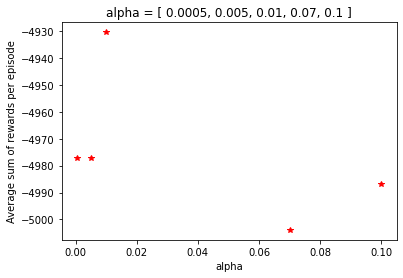

In [ ]:
plt.title('alpha = [ {}, {}, {}, {}, {} ]'.format(0.0005,0.005,0.01,0.07,0.1))
plt.xlabel('alpha')
plt.ylabel('Average sum of rewards per episode')
plt.plot(alpha,np.mean(np.array(rew_per_ep),axis=1),'r*',label='No of episodes = {}'.format(100))

**learning curve of the policies learnt in each case**<br>
 In learning curve, I am considering the rewards earned by the current
 optimal policy (after kth episode) by rendering it.
 In render, the max steps is 2000(for below graphs), that is if the agent is not able to reach
 destination in 30 steps, the rendering is stopped with message that the task failed.<br>
<br>
 If we do not restrict steps in rendering, then non optimal policy will keep running
 indefinitely as there is only one way of termination (reaching goal).

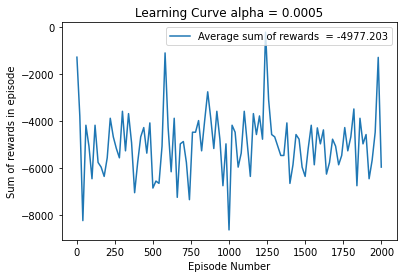

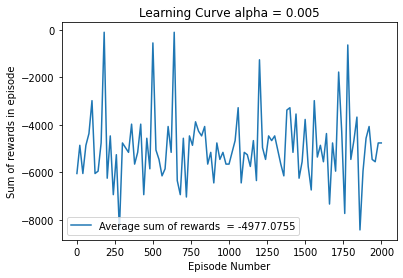

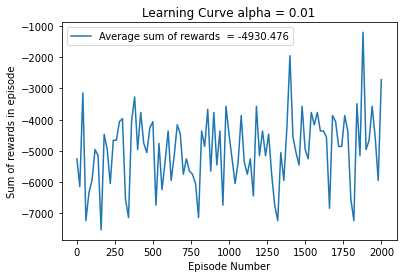

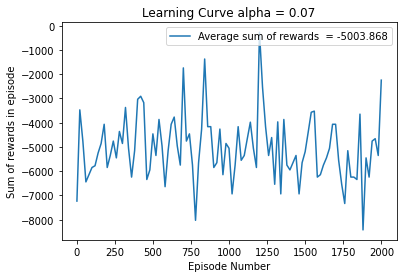

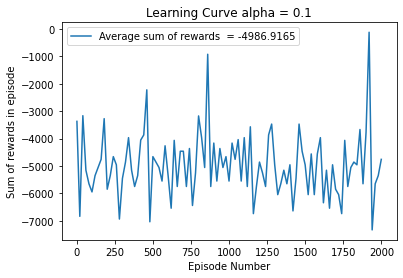

In [ ]:
for i in range(len(alpha)):
  plt.xlabel('Episode Number')
  plt.ylabel('Sum of rewards in episode')
  plt.title('Learning Curve alpha = {}'.format(alpha[i]))
  plt.plot([max(20*j-1,0) for j in range(101)],[rew_per_ep[i][max(20*j-1,0)] for j in range(101)],label='Average sum of rewards  = {}'.format(np.mean(rew_per_ep[i])))
  plt.legend()
  plt.show()


**Rendering the final policies obtained in Q1**

In [ ]:
rew_render = []
status_render = []
for i in range(len(alpha)):
  rew,status = cliff_render_reward(pol_list[i])
  rew_render.append(rew)
  status_render.append(status)
for i in range(len(alpha)):
  print('For alpha = {}'.format(alpha[i]))
  print('Reward Earned = {}'.format(rew_render[i]))
  print('Task Status = {}\n'.format(status_render[i]))
  env1 = wrap_env(gym.make("CliffWalking-v0",render_mode='rgb_array'))
  cliff_render(env1,pol_list[i])
  env1.close()
  show_video()

For alpha = 0.0005
Reward Earned = -300
Task Status = Failed



For alpha = 0.005
Reward Earned = -300
Task Status = Failed



For alpha = 0.01
Reward Earned = -300
Task Status = Failed



For alpha = 0.07
Reward Earned = -300
Task Status = Failed



For alpha = 0.1
Reward Earned = -13
Task Status = Success



#**Q2**

In [ ]:
epsilon = [0.1, 0.25, 0.55, 0.76, 0.95]

In [ ]:
import time
pol_list_epsilon = []
rew_per_ep_epsilon = []
Q_list_epsilon = []
run_time_epsilon = []
for e in epsilon:
    print('Running for epsilon = {}'.format(e))
    env = gym.make("CliffWalking-v0",render_mode=None)
    start = time.time()
    Q,pol,re = q_learning_eps_greedy(env,e,1000,alpha=0.0001)
    end = time.time()
    run_time = np.round((end-start),3)
    run_time_epsilon.append(run_time)
    print('For epsilon = {}, Runtime = {} s'.format(e,run_time))
    pol_list_epsilon.append(pol)
    rew_per_ep_epsilon.append(re)
    Q_list_epsilon.append(Q)

Running for epsilon = 0.1
For epsilon = 0.1, Runtime = 60.876 s
Running for epsilon = 0.25
For epsilon = 0.25, Runtime = 38.234 s
Running for epsilon = 0.55
For epsilon = 0.55, Runtime = 41.914 s
Running for epsilon = 0.76
For epsilon = 0.76, Runtime = 37.736 s
Running for epsilon = 0.95
For epsilon = 0.95, Runtime = 40.384 s


 **Effect of  𝜖 on the performance of Q-Learning**<br>
 It can be seen above that as epsilon increases, the runtime remains nearly same. This is because the learning rate (alpha) is very low (0.0001) and hence none of the epsilon is able to make the algorithm converge, hence same runtime restricted by number of episodes.<br>
 Below is the graph of runtime vs epsilon.
 Also, higher epsilon is able to reach destination (see render section).

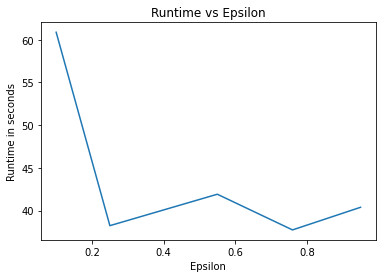

In [ ]:
plt.title('Runtime vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Runtime in seconds')
plt.plot(epsilon,run_time_epsilon)

**Graph of Epsilon with Average Q-values for start State(3,0) ,state(0,4) , state (1,7) and state(2,9)**<br>
with increase in epsilon the value of the these states decreases because more epsilon implies more exploration which increases the risk of falling into cliff.

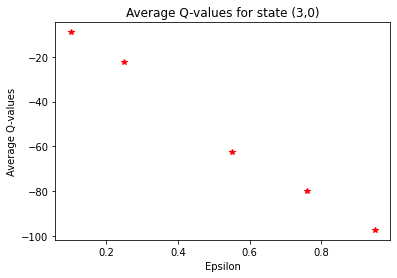

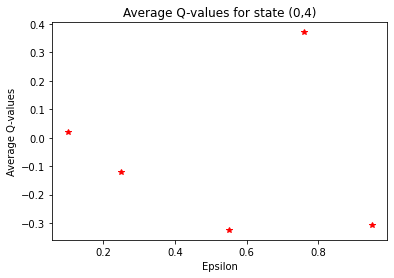

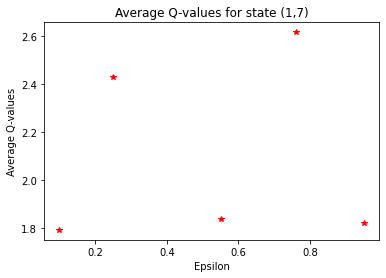

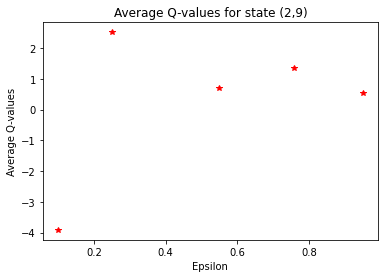

In [ ]:
states = [[3,0], [0,4], [1,7], [2,9]]
for state in states:
  state_val = 12*state[0] + state[1]
  plt.title('Average Q-values for state ({},{})'.format(state[0],state[1]))
  plt.xlabel('Epsilon')
  plt.ylabel('Average Q-values')
  plt.plot(epsilon,[np.sum(Q_list_epsilon[i][state_val]) for i in range(len(epsilon))],'r*')
  plt.show()

**Rendering the policies obtained in Q2**

In [ ]:
rew_render_eps = []
status_render_eps = []
for i in range(len(epsilon)):
  rew_eps,status_eps = cliff_render_reward(pol_list[i])
  rew_render_eps.append(rew_eps)
  status_render_eps.append(status_eps)
for i in range(len(epsilon)):
  print('For epsilon = {}'.format(epsilon[i]))
  print('Reward Earned = {}'.format(rew_render_eps[i]))
  print('Task Status = {}\n'.format(status_render_eps[i]))
  env1 = wrap_env(gym.make("CliffWalking-v0",render_mode='rgb_array'))
  cliff_render(env1,pol_list[i])
  env1.close()
  show_video()

For epsilon = 0.1
Reward Earned = -300
Task Status = Failed



For epsilon = 0.25
Reward Earned = -300
Task Status = Failed



For epsilon = 0.55
Reward Earned = -300
Task Status = Failed



For epsilon = 0.76
Reward Earned = -300
Task Status = Failed



For epsilon = 0.95
Reward Earned = -13
Task Status = Success



#**Q3**<br>
**What is the relationship/similarities between Purely Random policy and $ϵ$- greedy policy? Comment on the performance difference among these policies. Is Random Policy a special case of  $ϵ$-Greedy policy?**

**Ans**<br>
A random policy does extreme exploration (does not exploit at all) whereas an ϵ - greedy policy does both exploration and exploitation (with ϵ probability, it explores and with (1-ϵ) probability it exploits).<br>
From Q1 and Q2 render results, we can say that ϵ - greedy policy performs better than random policy.<br>
Yes, random policy is a special case (extreme exploration) of ϵ - greedy policy corresponding to ϵ = 1

#**Q4**

In [ ]:
env = gym.make("CliffWalking-v0",render_mode=None)
# In the following function, after each episode epsilon is update to 0.99907939*epsilon,
# so, in 5000 iterations it will go from 1 to 0.01
Q_eps_decr,pol_eps_decr,rew_eps_decr = q_learning_eps_greedy_decreasing(env,n_episode=5000,epsilon=1,alpha=0.01)


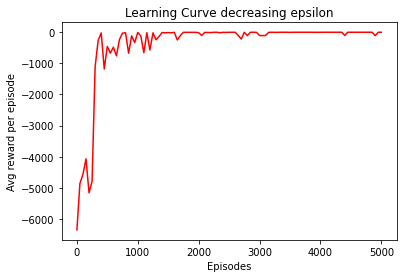

In [ ]:
plt.title('Learning Curve decreasing epsilon')
plt.xlabel('Episodes')
plt.ylabel('Avg reward per episode')
plt.plot([max(50*i- 1,0) for i in range(101)],[rew_eps_decr[max(50*i-1,0)] for i in range(101)],'r-')
plt.show()

We can see that in case of decreasing ϵ, the learning rate fluctuates less as number of episodes increases (ϵ decreases) because exploration decreases.<br>
But in case of constant ϵ, the learning curve keeps fluctuating a lot because it does a lot of exploration throughout all episode since ϵ = 1

##**Render Policy using decreasing epsilon**

In [ ]:
rew_eps_decr,status_eps_decr = cliff_render_reward(pol_eps_decr)
print('Reward = {}, Status = {}'.format(rew_eps_decr,status_eps_decr))
env1 = wrap_env(gym.make("CliffWalking-v0",render_mode='rgb_array'))
cliff_render(env1,pol_eps_decr)
env1.close()
show_video()

Reward = -13, Status = Success
